# "Imputation"

Goal is as follows:

Moving to irregular grid
For each initial condition (and from REAL SOLUTION)
 - arbitrary # of time points (big enough)
 - arbitrary spacing between them
 - sample section @ those time points
     - https://stackoverflow.com/questions/6482889/get-random-sample-from-list-while-maintaining-ordering-of-items
 - fit a polynomial (cubic spline)
 - sample from the fit on a regular grid
 - Run SINDy on regular grid fit
 - test the solution MSE (SINDy - real)
 - MSE (polynomial values - real) as an extra
 
 ### 7/13
    Have sampled 75% of tvals at random spacing while preserving order in ONE trajectory using stackoverflow code. Need to apply to multiple trajectories. Same # of time points and spacing for all trajectories or no? 

    Maybe just wrap the code into a for loop of n_of_ic and conglomerate? But then need to resolve difference in length. That's what the polynomial is for? Build poly from sampled points and then use it to "put back" points onto our structure?
    
    NEXT STEP, look into fitting poly w/ cubic spline

 ### 7/14
    Had worries that I'd have trouble getting points outside of our sample time range (i.e. sampled points start at t=2 and we want to guess t=0 but spline only accounts for max(t)>t>2. Calling the constructed cubicspline method on something slightly outside seems to work though.

In [184]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
#import colorednoise as cn
import random
from scipy.interpolate import CubicSpline

In [163]:
# test cell
len(netswitch_train_multi[0][:, 0])
sample_size
range(len(first_traj[:, 0]))
mylist = [ 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 ,9  , 10 ]
indices = random.sample(range(len(mylist)), 3)
[mylist[i] for i in sorted(indices)]

[first_traj[i, :] for i in sorted(random.sample(range(len(first_traj[:, 0])), 3000)) ]
(np.random.randint(int(0.5 * n_of_t), n_of_t + 1))
rng = np.random.default_rng()
rng.integers(low=int(0.25 * n_of_t), high=n_of_t)

1552

In [4]:
# contains functions + basic parameters
a_u, a_v = 1, 1
beta, gamma = 2, 2
dudt = lambda u, v: -u + (a_u / (1+v**beta))
dvdt = lambda u, v: -v + (a_v / (1+u**gamma))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.8, 10)
netswitch = lambda t, x: np.array([dudt(x[0], x[1]), dvdt(x[0], x[1])])
# 0-5 minus some value between 0-1, no negatives for IC?
n_of_ic = 1000
u_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)
v_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)

def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["u", "v"]
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
library_functions = [
    lambda x: x,
    lambda x: 1 / (1 + x**1),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / (1 + x**3),
    lambda x: 1 / (1 + x**4),
    lambda x: 1 / (1 + x**5)
]
library_function_names = [
    lambda x: x,
    lambda x: '1/(1 + ' + x + '^1)',
    lambda x: '1/(1 + ' + x + '^2)',
    lambda x: '1/(1 + ' + x + '^3)',
    lambda x: '1/(1 + ' + x + '^4)',
    lambda x: '1/(1 + ' + x + '^5)'
]
netswitch_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [363]:
# creation of TRUE set
T = 50
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
n_of_t = 4000
tvals = np.linspace(0, T, n_of_t)
n_of_ic = 200
feature_count = 2
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
sparse_regression_optimizer = ps.STLSQ(threshold=0.7)
MSE_list = []
netswitch_train_multi = []
integrator_keywords = {}
#integrator_keywords['full_output'] = True
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

print(integrator_keywords)

# creation of TRUE data/solution
for i in range(n_of_ic):     
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)

{'rtol': 1e-12, 'method': 'LSODA', 'atol': 1e-12}


(4000, 2)
(1291, 2)


'\nprint((indices))\nprint((sorted_sample[:,0]))\nprint(cs_u(-40))'

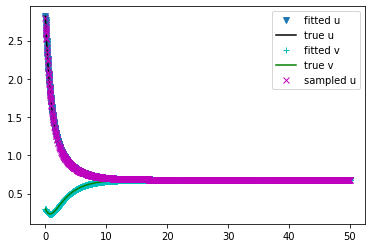

In [404]:

# 7/14 , for now, work on getting imputation steps done for one initial condition "first_traj".

rng = np.random.default_rng()
sample_size = rng.integers(low=int(0.25 * n_of_t), high=n_of_t)
first_traj = netswitch_train_multi[0]

indices = sorted(
    random.sample(range(len(first_traj[:, 0])), int(sample_size)))
sorted_sample = np.asarray([
    first_traj[i, :] for i in indices
])
print((first_traj).shape)
print(np.asarray(sorted_sample).shape)
# fit to corresponding time values and not the indices
cs_u = CubicSpline(tvals[indices], sorted_sample[:, 0])
cs_v = CubicSpline(tvals[indices], sorted_sample[:, 1])
"""
fig, axs = plt.subplots()
plt.plot(tvals, cs_u(tvals), "v", label="fitted u")
plt.plot(tvals, first_traj[:,0], 'k', label="true u")
plt.plot(tvals, cs_v(tvals), "c+", label="fitted v")
plt.plot(tvals, first_traj[:, 1], 'g', label="true v")
plt.plot(tvals[indices], sorted_sample[:, 0],"mx",label="sampled u")
plt.legend()
"""
"""
print((indices))
print((sorted_sample[:,0]))
print(cs_u(-40))"""
